### Biblioteki

In [92]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, classification_report


from xgboost import XGBClassifier
from matplotlib import pyplot as plt

In [2]:
from src.data.data_loader import train_test_split_data, create_dataloader
from src.data.utils import create_dataframe_from_csv_zst
from src.models.classifier import BinaryClassifier
from src.models.classifier_emb import BinaryClassifierEmbeddings
from src.models.naive_classifier import NaiveClassifier
from src.models.train_model import train_classifier, evaluate_model
from src.visualization.visualize import plot_confusion_matrix
from src.data.utils import create_dataframe_from_csv_zst

### Finałowy dataset

In [3]:
AMENITIES_PATH = "../data/processed/amenities_stats.csv.zst"
REVIEWS_STATISTICS_PATH = "../data/processed/merged_reviews_statistics.csv.zst"
LISTINGS_PATH = "../data/raw/v2/listings.csv.zst"
SESSIONS_STATISTICS_PATH = "../data/processed/listings_statistics.csv"

In [4]:
amenities_df = create_dataframe_from_csv_zst(AMENITIES_PATH)
reviews_statistics_df = create_dataframe_from_csv_zst(REVIEWS_STATISTICS_PATH)
listings_df = create_dataframe_from_csv_zst(LISTINGS_PATH)

/home/psik/GITHUB/IUM/IUM-long-stay-insights/src/data/utils.py:13: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [5]:
amenities_df.head(5)

,id,amenities,standardized_amenities,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities,mean_embedding
0,27262,"[""Heating - split type ductless system"", ""Dish...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'Refriger...",37,25,True,False,9,[-6.15361333e-02 -5.01407236e-02 -3.76954190e-...
1,809874,"[""Host greets you"", ""Dishes and silverware"", ""...","['OTHER', 'OTHER', 'Washer', 'TV', 'OTHER', 'R...",21,12,True,True,7,[-5.95615655e-02 -3.39257978e-02 -3.55266146e-...
2,866381,"[""Coffee"", ""Dishes and silverware"", ""Washer"", ...","['Coffee maker', 'OTHER', 'Washer', 'Condition...",49,29,True,True,12,[-5.62126637e-02 -3.99859361e-02 -3.53127755e-...
3,886724,"[""Host greets you"", ""Luggage dropoff allowed"",...","['OTHER', 'OTHER', 'Washer', 'OTHER', 'OTHER',...",20,13,True,True,6,[-5.84196560e-02 -4.62852195e-02 -3.04865874e-...
4,896212,"[""Host greets you"", ""Coffee"", ""Dishes and silv...","['OTHER', 'Coffee maker', 'OTHER', 'OTHER', 'O...",45,31,True,True,9,[-5.81393391e-02 -4.77810428e-02 -4.26256545e-...


In [6]:
reviews_statistics_df.head(5)

,listing_id,total_reviews,total_english_reviews,count_negative_english,count_positive_english
0,21853,33,17.0,1.0,16.0
1,27262,29,17.0,0.0,17.0
2,30320,172,133.0,15.0,118.0
3,30959,8,4.0,0.0,4.0
4,33945,78,60.0,2.0,58.0


In [7]:
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,27262,https://www.nocarz.pl/rooms/27262,20241225065837,2024-12-25,city scrape,"AQA-No7, Great mattress, high speed internet",THE MATTRESS - KING KOIL - Camden Luxury 160x2...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,37177,...,t,1,1,0,0,0.19,NaN,NaN,NaN,NaN
1,809874,https://www.nocarz.pl/rooms/809874,20241225065837,2024-12-25,city scrape,Wonderfull Penthouse!!,NaN,NaN,https://a0.muscache.com/pictures/11813063/7d06...,4259738,...,f,1,1,0,0,0.68,NaN,NaN,NaN,NaN
2,866381,https://www.nocarz.pl/rooms/866381,20241225065837,2024-12-25,city scrape,Acropolis View Funky House,Welcome to a colorful 7th-floor penthouse in N...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,4551671,...,f,1,1,0,0,0.28,NaN,NaN,NaN,NaN
3,886724,https://www.nocarz.pl/rooms/886724,20241225065837,2024-12-25,city scrape,Luxury Boutique Appartment -Athens,NaN,The apartment is very conveniently located for...,https://a0.muscache.com/pictures/14659524/b33a...,4700824,...,f,1,1,0,0,0.14,NaN,NaN,NaN,NaN
4,896212,https://www.nocarz.pl/rooms/896212,20241225065837,2024-12-25,city scrape,Living like in a cottage in the center of Athens,An oasis of calm in the centre of a crowded ci...,Exarchia is considered the bohemian and altern...,https://a0.muscache.com/pictures/prohost-api/H...,4777984,...,t,13,13,0,0,3.58,NaN,NaN,NaN,NaN


In [8]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [9]:
interesting_columns = [
    'id',
    'host_is_superhost',
    'host_verifications',
    'host_acceptance_rate',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bathrooms_text',
    'bedrooms',
    'beds',
    'price',
    'license',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'instant_bookable',
    'reviews_per_month',
    'availability_eoy',
    'number_of_reviews_ly'
]

In [10]:
final_df = listings_df[interesting_columns].copy()
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,availability_eoy,number_of_reviews_ly
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,4.89,4.90,4.86,4.97,4.75,4.71,t,0.19,NaN,NaN
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,4.97,4.97,4.89,4.92,4.86,4.91,f,0.68,NaN,NaN
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,4.98,4.98,4.93,4.93,4.73,4.90,f,0.28,NaN,NaN
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,4.88,4.47,4.88,4.89,4.28,4.72,f,0.14,NaN,NaN
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,4.94,4.96,4.97,4.93,4.82,4.93,t,3.58,NaN,NaN


In [11]:
listings_statistics = pd.read_csv(SESSIONS_STATISTICS_PATH)
listings_statistics.head(5)

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,num_of_short_stays,num_of_long_stays
0,21853.0,33,48,1.454545,1,4,33,0
1,27262.0,29,144,4.965517,2,7,29,0
2,30320.0,172,360,2.093023,1,4,172,0
3,30959.0,8,12,1.500000,1,3,8,0
4,33945.0,78,540,6.923077,3,10,54,24


In [12]:
listings_statistics['target'] = np.where(
    listings_statistics['num_of_short_stays'] > listings_statistics['num_of_long_stays'],
    'short',
    'long'
)

In [13]:
listings_statistics.head()

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,num_of_short_stays,num_of_long_stays,target
0,21853.0,33,48,1.454545,1,4,33,0,short
1,27262.0,29,144,4.965517,2,7,29,0,short
2,30320.0,172,360,2.093023,1,4,172,0,short
3,30959.0,8,12,1.500000,1,3,8,0,short
4,33945.0,78,540,6.923077,3,10,54,24,short


In [14]:
listing_statistics_final_df = listings_statistics[['listing_id','total_bookings', 'target']].copy()

In [15]:
listing_statistics_final_df.head(5)

,listing_id,total_bookings,target
0,21853.0,33,short
1,27262.0,29,short
2,30320.0,172,short
3,30959.0,8,short
4,33945.0,78,short


### Złączenie datasetów

In [16]:
final_df = final_df.merge(
    listing_statistics_final_df,
    left_on='id',
    right_on='listing_id',
    how='left'
)
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,availability_eoy,number_of_reviews_ly,listing_id,total_bookings,target
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,4.97,4.75,4.71,t,0.19,NaN,NaN,27262.0,29.0,short
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,4.92,4.86,4.91,f,0.68,NaN,NaN,809874.0,97.0,short
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,4.93,4.73,4.90,f,0.28,NaN,NaN,866381.0,40.0,long
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,4.89,4.28,4.72,f,0.14,NaN,NaN,886724.0,18.0,short
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,4.93,4.82,4.93,t,3.58,NaN,NaN,896212.0,515.0,long


In [17]:
final_df= final_df.merge(
    reviews_statistics_df,
    left_on='id',
    right_on='listing_id',
    how='left'
)
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,availability_eoy,number_of_reviews_ly,listing_id_x,total_bookings,target,listing_id_y,total_reviews,total_english_reviews,count_negative_english,count_positive_english
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,NaN,NaN,27262.0,29.0,short,27262.0,29.0,17.0,0.0,17.0
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,NaN,NaN,809874.0,97.0,short,809874.0,97.0,82.0,0.0,82.0
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,NaN,NaN,866381.0,40.0,long,866381.0,40.0,31.0,0.0,31.0
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,NaN,NaN,886724.0,18.0,short,886724.0,18.0,17.0,1.0,16.0
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,NaN,NaN,896212.0,515.0,long,896212.0,515.0,423.0,3.0,420.0


In [18]:
final_df = final_df.merge(
    amenities_df,
    left_on='id',
    right_on='id',
    how='left'
)
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,count_negative_english,count_positive_english,amenities,standardized_amenities,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities,mean_embedding
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,0.0,17.0,"[""Heating - split type ductless system"", ""Dish...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'Refriger...",37,25,True,False,9,[-6.15361333e-02 -5.01407236e-02 -3.76954190e-...
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,0.0,82.0,"[""Host greets you"", ""Dishes and silverware"", ""...","['OTHER', 'OTHER', 'Washer', 'TV', 'OTHER', 'R...",21,12,True,True,7,[-5.95615655e-02 -3.39257978e-02 -3.55266146e-...
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,0.0,31.0,"[""Coffee"", ""Dishes and silverware"", ""Washer"", ...","['Coffee maker', 'OTHER', 'Washer', 'Condition...",49,29,True,True,12,[-5.62126637e-02 -3.99859361e-02 -3.53127755e-...
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,1.0,16.0,"[""Host greets you"", ""Luggage dropoff allowed"",...","['OTHER', 'OTHER', 'Washer', 'OTHER', 'OTHER',...",20,13,True,True,6,[-5.84196560e-02 -4.62852195e-02 -3.04865874e-...
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,3.0,420.0,"[""Host greets you"", ""Coffee"", ""Dishes and silv...","['OTHER', 'Coffee maker', 'OTHER', 'OTHER', 'O...",45,31,True,True,9,[-5.81393391e-02 -4.77810428e-02 -4.26256545e-...


In [19]:
# how to drop target column with NaN?
final_df = final_df.dropna(subset=['target'])

In [20]:
# changing price to a numerical value
final_df['price'] = final_df['price'].replace('[\$,]', '', regex=True).astype(float)

In [21]:
# droppin unnecesery columns
final_df.drop(columns=['listing_id_x', 'listing_id_y'], inplace=True)

In [22]:
# changing host_avaialbility_rate to a number
final_df['host_acceptance_rate'] = final_df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

### Statystyki ostatecznego datasetu

In [23]:
final_df_numerical_columns = final_df.select_dtypes(include=[np.number, np.bool]).columns.tolist()
final_df_categorical_columns = final_df.select_dtypes(exclude=[np.number, np.bool]).columns.tolist()

print("Numerical columns: ", final_df_numerical_columns)
print("Categorical columns: ", final_df_categorical_columns)

Numerical columns:  ['id', 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'availability_eoy', 'number_of_reviews_ly', 'total_bookings', 'total_reviews', 'total_english_reviews', 'count_negative_english', 'count_positive_english', 'num_of_amenities', 'num_of_other_amenities', 'has_wifi', 'has_air_conditioning', 'num_of_top_10_common_amenities']
Categorical columns:  ['host_is_superhost', 'host_verifications', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'license', 'instant_bookable', 'target', 'amenities', 'standardized_amenities', 'mean_embedding']


# Klasyfikatory

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Naiwny

In [25]:
numerical_df = final_df[final_df_numerical_columns + ['target']].copy()
numerical_df = numerical_df.fillna(0)
numerical_df = numerical_df.drop(columns=['id'])
numerical_df.head(5)


,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,review_scores_accuracy,...,total_reviews,total_english_reviews,count_negative_english,count_positive_english,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities,target
0,100.0,37.98924,23.76500,2,1.0,1.0,1.0,131.0,4.86,4.89,...,29.0,17.0,0.0,17.0,37,25,True,False,9,short
1,96.0,37.96215,23.72179,4,1.0,1.0,2.0,108.0,4.96,4.97,...,97.0,82.0,0.0,82.0,21,12,True,True,7,short
2,97.0,37.95523,23.72443,3,1.0,1.0,1.0,85.0,4.95,4.98,...,40.0,31.0,0.0,31.0,49,29,True,True,12,long
3,0.0,37.99745,23.73973,2,1.0,1.0,1.0,56.0,4.61,4.88,...,18.0,17.0,1.0,16.0,20,13,True,True,6,short
4,100.0,37.98844,23.73845,2,1.0,1.0,1.0,63.0,4.95,4.94,...,515.0,423.0,3.0,420.0,45,31,True,True,9,long


In [26]:
numerical_df.shape

(28807, 29)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split_data(df=numerical_df, test_size=0.2, target_column='target')

# adding validation set
x_train_final, x_val, y_train_final, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

train_dataloader = create_dataloader(x_train_final, y_train_final, batch_size=32)
val_dataloader = create_dataloader(x_val, y_val, batch_size=32)
test_dataloader = create_dataloader(x_test, y_test, batch_size=32)

In [97]:
naive_classifier = NaiveClassifier(input_size=len(x_train.columns), output=0).to(device)

In [37]:
all_preds, all_labels = evaluate_model(naive_classifier, test_dataloader)

Evaluating: 100%|██████████| 181/181 [00:00<00:00, 744.08it/s]

Accuracy: 0.7805
ROC AUC: 0.5000
Average Precision: 0.2195


In [38]:
y_pred = np.argmax(all_preds, axis=1)

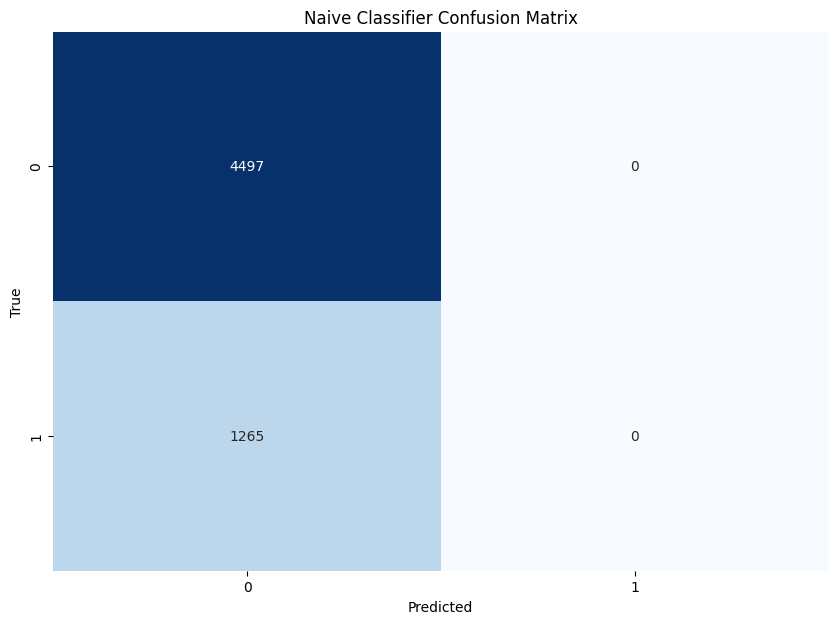

In [39]:
plot_confusion_matrix(all_labels, y_pred, title='Naive Classifier Confusion Matrix')

In [98]:
torch.save(naive_classifier.state_dict(), "../models/NaiveClassifier.pth")

#### Wersja 1 - Dane Numeryczne

In [40]:
classifier_v1 = BinaryClassifier(input_size=len(x_train.columns), output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_v1.parameters(), lr=0.001)

In [41]:
train_classifier(
    model=classifier_v1,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    device=device
)

Epoch [1/50] | Train Loss: 0.3845 | Val Loss: 0.2963 | Val Acc: 0.8596


Epoch [2/50] | Train Loss: 0.2966 | Val Loss: 0.2840 | Val Acc: 0.8629


Epoch [3/50] | Train Loss: 0.2755 | Val Loss: 0.2909 | Val Acc: 0.8551


Epoch [4/50] | Train Loss: 0.2629 | Val Loss: 0.2608 | Val Acc: 0.8670


Epoch [5/50] | Train Loss: 0.2571 | Val Loss: 0.2540 | Val Acc: 0.8748


Epoch [6/50] | Train Loss: 0.2505 | Val Loss: 0.2469 | Val Acc: 0.8759


Epoch [7/50] | Train Loss: 0.2459 | Val Loss: 0.2576 | Val Acc: 0.8653


Epoch [8/50] | Train Loss: 0.2450 | Val Loss: 0.2444 | Val Acc: 0.8742


Epoch [9/50] | Train Loss: 0.2391 | Val Loss: 0.2311 | Val Acc: 0.8813


Epoch [10/50] | Train Loss: 0.2377 | Val Loss: 0.2354 | Val Acc: 0.8791


Epoch [11/50] | Train Loss: 0.2344 | Val Loss: 0.2347 | Val Acc: 0.8789


Epoch [12/50] | Train Loss: 0.2320 | Val Loss: 0.2564 | Val Acc: 0.8739


Epoch [13/50] | Train Loss: 0.2339 | Val Loss: 0.2470 | Val Acc: 0.8726


Epoch [14/50] | Train Loss: 0.2336 | Val Loss: 0.2356 | Val Acc: 0.8744


Epoch [15/50] | Train Loss: 0.2295 | Val Loss: 0.2387 | Val Acc: 0.8731


Epoch [16/50] | Train Loss: 0.2318 | Val Loss: 0.2274 | Val Acc: 0.8844


Epoch [17/50] | Train Loss: 0.2254 | Val Loss: 0.2244 | Val Acc: 0.8839


Epoch [18/50] | Train Loss: 0.2282 | Val Loss: 0.2436 | Val Acc: 0.8785


Epoch [19/50] | Train Loss: 0.2222 | Val Loss: 0.2213 | Val Acc: 0.8865


Epoch [20/50] | Train Loss: 0.2253 | Val Loss: 0.2416 | Val Acc: 0.8787


Epoch [21/50] | Train Loss: 0.2250 | Val Loss: 0.2352 | Val Acc: 0.8828


Epoch [22/50] | Train Loss: 0.2215 | Val Loss: 0.2462 | Val Acc: 0.8713


Epoch [23/50] | Train Loss: 0.2233 | Val Loss: 0.2334 | Val Acc: 0.8826


Epoch [24/50] | Train Loss: 0.2194 | Val Loss: 0.2262 | Val Acc: 0.8852


Epoch [25/50] | Train Loss: 0.2176 | Val Loss: 0.2390 | Val Acc: 0.8770


Epoch [26/50] | Train Loss: 0.2178 | Val Loss: 0.2308 | Val Acc: 0.8820


Epoch [27/50] | Train Loss: 0.2213 | Val Loss: 0.2263 | Val Acc: 0.8831


Epoch [28/50] | Train Loss: 0.2169 | Val Loss: 0.2295 | Val Acc: 0.8822


Epoch [29/50] | Train Loss: 0.2193 | Val Loss: 0.2351 | Val Acc: 0.8800


Epoch [30/50] | Train Loss: 0.2180 | Val Loss: 0.2267 | Val Acc: 0.8870


Epoch [31/50] | Train Loss: 0.2163 | Val Loss: 0.2223 | Val Acc: 0.8848


Epoch [32/50] | Train Loss: 0.2126 | Val Loss: 0.2233 | Val Acc: 0.8889


Epoch [33/50] | Train Loss: 0.2144 | Val Loss: 0.2235 | Val Acc: 0.8889


Epoch [34/50] | Train Loss: 0.2128 | Val Loss: 0.2276 | Val Acc: 0.8841


Epoch [35/50] | Train Loss: 0.2119 | Val Loss: 0.2236 | Val Acc: 0.8870


Epoch [36/50] | Train Loss: 0.2145 | Val Loss: 0.2224 | Val Acc: 0.8867


Epoch [37/50] | Train Loss: 0.2138 | Val Loss: 0.2391 | Val Acc: 0.8813


Epoch [38/50] | Train Loss: 0.2207 | Val Loss: 0.2374 | Val Acc: 0.8798


Epoch [39/50] | Train Loss: 0.2162 | Val Loss: 0.2265 | Val Acc: 0.8850


Epoch [40/50] | Train Loss: 0.2089 | Val Loss: 0.2231 | Val Acc: 0.8865


Epoch [41/50] | Train Loss: 0.2096 | Val Loss: 0.2225 | Val Acc: 0.8904


Epoch [42/50] | Train Loss: 0.2104 | Val Loss: 0.2316 | Val Acc: 0.8922


Epoch [43/50] | Train Loss: 0.2070 | Val Loss: 0.2465 | Val Acc: 0.8802


Epoch [44/50] | Train Loss: 0.2075 | Val Loss: 0.2215 | Val Acc: 0.8883


Epoch [45/50] | Train Loss: 0.2087 | Val Loss: 0.2419 | Val Acc: 0.8796


Epoch [46/50] | Train Loss: 0.2038 | Val Loss: 0.2197 | Val Acc: 0.8887


Epoch [47/50] | Train Loss: 0.2065 | Val Loss: 0.2429 | Val Acc: 0.8848


Epoch [48/50] | Train Loss: 0.2069 | Val Loss: 0.2295 | Val Acc: 0.8861


Epoch [49/50] | Train Loss: 0.2048 | Val Loss: 0.2428 | Val Acc: 0.8774


Epoch [50/50] | Train Loss: 0.2038 | Val Loss: 0.2411 | Val Acc: 0.8831
Training complete!


Evaluating: 100%|██████████| 181/181 [00:00<00:00, 391.31it/s]


Accuracy: 0.8830
ROC AUC: 0.9487
Average Precision: 0.8231


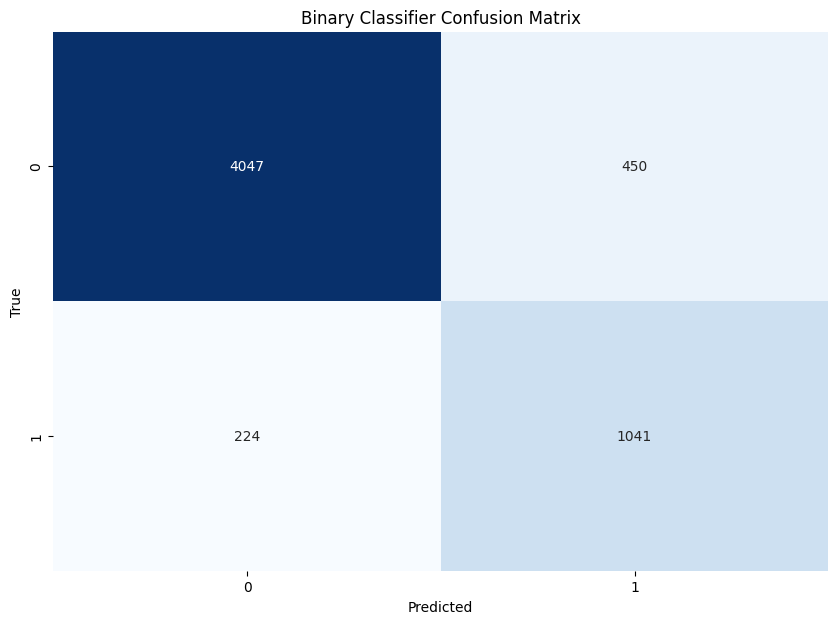

In [ ]:
all_preds, all_labels = evaluate_model(classifier_v1, test_dataloader)
y_pred = np.argmax(all_preds, axis=1)
plot_confusion_matrix(all_labels, y_pred, title='Binary Classifier (Numerical Features) Confusion Matrix')

### Wersja 2 - One Hot Encoding

In [82]:
final_df_ohe = final_df.copy()

In [83]:
final_df_ohe.drop(
    columns=['id', 'mean_embedding', 'listing_id_x', 'listing_id_y', 'amenities', 'standardized_amenities', 'neighbourhood_cleansed', 'license'],
    inplace=True,
    errors='ignore'
)
final_df_ohe.head()

,host_is_superhost,host_verifications,host_acceptance_rate,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,...,target,total_reviews,total_english_reviews,count_negative_english,count_positive_english,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities
0,t,"['email', 'phone']",100.0,37.98924,23.76500,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,29.0,17.0,0.0,17.0,37,25,True,False,9
1,f,"['email', 'phone']",96.0,37.96215,23.72179,Entire rental unit,Entire home/apt,4,1.0,1 bath,...,short,97.0,82.0,0.0,82.0,21,12,True,True,7
2,t,"['email', 'phone', 'work_email']",97.0,37.95523,23.72443,Entire condo,Entire home/apt,3,1.0,1 bath,...,long,40.0,31.0,0.0,31.0,49,29,True,True,12
3,f,['email'],0.0,37.99745,23.73973,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,18.0,17.0,1.0,16.0,20,13,True,True,6
4,t,"['email', 'phone']",100.0,37.98844,23.73845,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,long,515.0,423.0,3.0,420.0,45,31,True,True,9


In [86]:
non_numerical_columns = final_df_ohe.select_dtypes(include=['object', 'category']).columns
non_numerical_columns = non_numerical_columns.drop('target')
print(non_numerical_columns)

Index(['host_is_superhost', 'host_verifications', 'property_type', 'room_type',
       'bathrooms_text', 'instant_bookable'],
      dtype='object')


In [46]:
# one_hot_encoding
ohe_df = pd.get_dummies(final_df_ohe, columns=non_numerical_columns)

In [ ]:
# dropping them as they contain a lot of missing values
ohe_df.drop(columns=['availability_eoy', 'number_of_reviews_ly'], inplace=True)

In [48]:
# filling missin values with 0 -> later we need to find a better solution for missing values
ohe_df = ohe_df.fillna(0)

In [49]:
x_train, x_test, y_train, y_test = train_test_split_data(df=ohe_df, test_size=0.2, target_column='target')

# adding validation set
x_train_final, x_val, y_train_final, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

train_dataloader = create_dataloader(x_train_final, y_train_final, batch_size=32)
val_dataloader = create_dataloader(x_val, y_val, batch_size=32)
test_dataloader = create_dataloader(x_test, y_test, batch_size=32)

In [50]:
classifier_v2 = BinaryClassifier(input_size=len(x_train_final.columns), output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_v2.parameters(), lr=0.001)

In [ ]:
# assertions to check data integrity
assert not x_train.isnull().any().any(), "NaNs found in x_train"
assert not np.isinf(x_train.to_numpy()).any(), "Infs found in x_train"
assert set(y_train.unique()).issubset({0, 1}), "Invalid labels in y_train"

In [52]:
train_classifier(
    model=classifier_v2,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    device=device
)

Epoch [1/50] | Train Loss: 0.2980 | Val Loss: 0.2539 | Val Acc: 0.8785


Epoch [2/50] | Train Loss: 0.2082 | Val Loss: 0.2239 | Val Acc: 0.8965


Epoch [3/50] | Train Loss: 0.1911 | Val Loss: 0.1928 | Val Acc: 0.9078


Epoch [4/50] | Train Loss: 0.1765 | Val Loss: 0.1778 | Val Acc: 0.9117


Epoch [5/50] | Train Loss: 0.1734 | Val Loss: 0.1907 | Val Acc: 0.9115


Epoch [6/50] | Train Loss: 0.1702 | Val Loss: 0.1816 | Val Acc: 0.9163


Epoch [7/50] | Train Loss: 0.1588 | Val Loss: 0.1525 | Val Acc: 0.9278


Epoch [8/50] | Train Loss: 0.1552 | Val Loss: 0.1668 | Val Acc: 0.9176


Epoch [9/50] | Train Loss: 0.1559 | Val Loss: 0.1980 | Val Acc: 0.9128


Epoch [10/50] | Train Loss: 0.1523 | Val Loss: 0.1469 | Val Acc: 0.9312


Epoch [11/50] | Train Loss: 0.1493 | Val Loss: 0.1519 | Val Acc: 0.9280


Epoch [12/50] | Train Loss: 0.1501 | Val Loss: 0.1663 | Val Acc: 0.9256


Epoch [13/50] | Train Loss: 0.1463 | Val Loss: 0.1922 | Val Acc: 0.9084


Epoch [14/50] | Train Loss: 0.1403 | Val Loss: 0.1407 | Val Acc: 0.9358


Epoch [15/50] | Train Loss: 0.1448 | Val Loss: 0.1523 | Val Acc: 0.9280


Epoch [16/50] | Train Loss: 0.1442 | Val Loss: 0.1473 | Val Acc: 0.9286


Epoch [17/50] | Train Loss: 0.1383 | Val Loss: 0.1528 | Val Acc: 0.9291


Epoch [18/50] | Train Loss: 0.1367 | Val Loss: 0.1593 | Val Acc: 0.9251


Epoch [19/50] | Train Loss: 0.1392 | Val Loss: 0.1613 | Val Acc: 0.9278


Epoch [20/50] | Train Loss: 0.1411 | Val Loss: 0.1592 | Val Acc: 0.9254


Epoch [21/50] | Train Loss: 0.1377 | Val Loss: 0.1509 | Val Acc: 0.9325


Epoch [22/50] | Train Loss: 0.1339 | Val Loss: 0.1577 | Val Acc: 0.9234


Epoch [23/50] | Train Loss: 0.1353 | Val Loss: 0.1519 | Val Acc: 0.9306


Epoch [24/50] | Train Loss: 0.1301 | Val Loss: 0.1403 | Val Acc: 0.9356


Epoch [25/50] | Train Loss: 0.1299 | Val Loss: 0.1734 | Val Acc: 0.9176


Epoch [26/50] | Train Loss: 0.1293 | Val Loss: 0.1477 | Val Acc: 0.9317


Epoch [27/50] | Train Loss: 0.1254 | Val Loss: 0.1446 | Val Acc: 0.9351


Epoch [28/50] | Train Loss: 0.1317 | Val Loss: 0.1484 | Val Acc: 0.9345


Epoch [29/50] | Train Loss: 0.1244 | Val Loss: 0.1650 | Val Acc: 0.9241


Epoch [30/50] | Train Loss: 0.1283 | Val Loss: 0.1370 | Val Acc: 0.9390


Epoch [31/50] | Train Loss: 0.1284 | Val Loss: 0.1696 | Val Acc: 0.9343


Epoch [32/50] | Train Loss: 0.1243 | Val Loss: 0.1564 | Val Acc: 0.9236


Epoch [33/50] | Train Loss: 0.1252 | Val Loss: 0.1515 | Val Acc: 0.9280


Epoch [34/50] | Train Loss: 0.1234 | Val Loss: 0.1505 | Val Acc: 0.9336


Epoch [35/50] | Train Loss: 0.1274 | Val Loss: 0.1487 | Val Acc: 0.9358


Epoch [36/50] | Train Loss: 0.1233 | Val Loss: 0.1469 | Val Acc: 0.9351


Epoch [37/50] | Train Loss: 0.1220 | Val Loss: 0.1599 | Val Acc: 0.9254


Epoch [38/50] | Train Loss: 0.1196 | Val Loss: 0.1475 | Val Acc: 0.9314


Epoch [39/50] | Train Loss: 0.1235 | Val Loss: 0.1440 | Val Acc: 0.9317


Epoch [40/50] | Train Loss: 0.1214 | Val Loss: 0.1544 | Val Acc: 0.9336


Epoch [41/50] | Train Loss: 0.1210 | Val Loss: 0.1388 | Val Acc: 0.9390


Epoch [42/50] | Train Loss: 0.1203 | Val Loss: 0.1386 | Val Acc: 0.9366


Epoch [43/50] | Train Loss: 0.1222 | Val Loss: 0.1379 | Val Acc: 0.9384


Epoch [44/50] | Train Loss: 0.1235 | Val Loss: 0.1418 | Val Acc: 0.9373


Epoch [45/50] | Train Loss: 0.1198 | Val Loss: 0.1841 | Val Acc: 0.9241


Epoch [46/50] | Train Loss: 0.1216 | Val Loss: 0.1391 | Val Acc: 0.9395


Epoch [47/50] | Train Loss: 0.1184 | Val Loss: 0.1507 | Val Acc: 0.9312


Epoch [48/50] | Train Loss: 0.1169 | Val Loss: 0.1390 | Val Acc: 0.9406


Epoch [49/50] | Train Loss: 0.1158 | Val Loss: 0.1422 | Val Acc: 0.9377


Epoch [50/50] | Train Loss: 0.1185 | Val Loss: 0.1400 | Val Acc: 0.9406
Training complete!


Evaluating: 100%|██████████| 181/181 [00:00<00:00, 365.83it/s]


Accuracy: 0.9413
ROC AUC: 0.9838
Average Precision: 0.9513


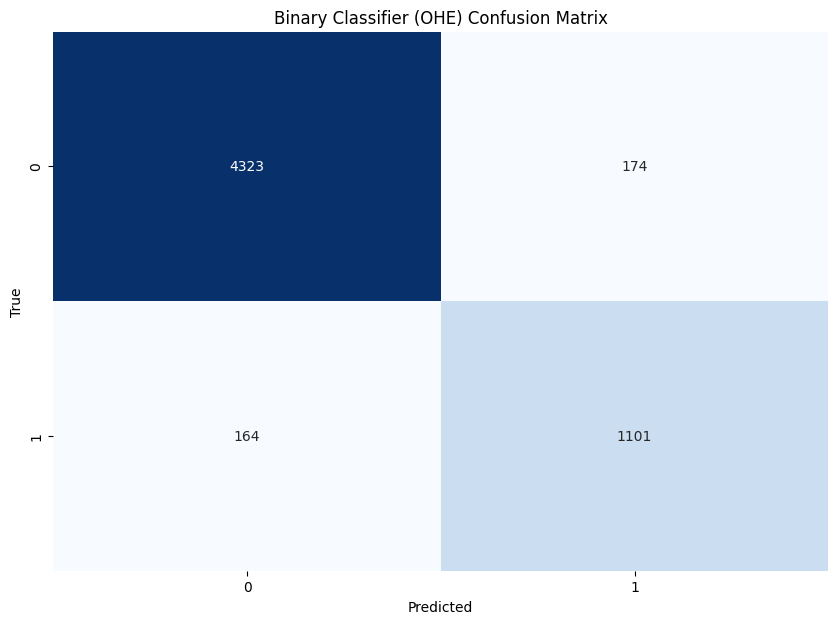

In [53]:
all_preds, all_labels = evaluate_model(classifier_v2, test_dataloader, device)
y_pred = np.argmax(all_preds, axis=1)
plot_confusion_matrix(all_labels, y_pred, title='Binary Classifier (OHE) Confusion Matrix')

In [54]:
torch.save(classifier_v2.state_dict(), "../models/OHE_CLASSIFIER.pth")

### Wersja 3 - Embeddingi

In [61]:
embeddings = final_df.copy()

In [62]:
embeddings = embeddings.drop(columns=['availability_eoy','number_of_reviews_ly', 'id', 'amenities', 'standardized_amenities'])
embeddings = embeddings.fillna(0)

In [64]:
emb_categorical_columns = embeddings.select_dtypes(include=['object', 'category']).columns
# delete target column from categorical columns
emb_categorical_columns = emb_categorical_columns.drop('target')
print(emb_categorical_columns)

Index(['host_is_superhost', 'host_verifications', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'bathrooms_text', 'license',
       'instant_bookable', 'mean_embedding'],
      dtype='object')


In [65]:
emb_numerical_columns = embeddings.select_dtypes(include=['number']).columns
print(emb_numerical_columns)

Index(['host_acceptance_rate', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'total_bookings', 'total_reviews', 'total_english_reviews',
       'count_negative_english', 'count_positive_english', 'num_of_amenities',
       'num_of_other_amenities', 'num_of_top_10_common_amenities'],
      dtype='object')


In [66]:
if isinstance(emb_categorical_columns, pd.Index):
    print("emb_categorical_columns is a pandas Index. Converting to list.")
    emb_categorical_columns = emb_categorical_columns.tolist()

x_cat_train, x_cat_test, x_num_train, x_num_test, y_train, y_test = train_test_split_data(
    df=embeddings,
    emb_categorical_columns=emb_categorical_columns,
    test_size=0.2,
    target_column='target'
)

# adding validation set
x_cat_train_final, x_cat_val, x_num_train_final, x_num_val, y_train_final, y_val = train_test_split(
    x_cat_train,
    x_num_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

emb_train_dataloader = create_dataloader(x_cat_train_final, y_train_final, x_num_train_final, batch_size=32)
emb_val_dataloader = create_dataloader(x_cat_val, y_val, x_num_val, batch_size=32)
emb_test_dataloader = create_dataloader(x_cat_test, y_test, x_num_test, batch_size=32)

emb_categorical_columns is a pandas Index. Converting to list.


In [67]:
assert list(x_cat_train_final.columns) == list(x_cat_val.columns), "Categorical columns in train and val dataloaders do not match"
assert list(x_num_train_final.columns) == list(x_num_val.columns), "Numerical columns in train and val dataloaders do not match"
assert not x_cat_train_final.isnull().any().any(), "NaNs found in x_cat_train_final"

In [ ]:
embedding_sizes = [
    (len(embeddings[col].astype('category').cat.categories), min(50, (len(embeddings[col].astype('category').cat.categories) + 1) // 2))
    for col in emb_categorical_columns
]

In [69]:
classifier_v3 = BinaryClassifierEmbeddings(
    num_numeric=x_num_train_final.shape[1],
    embedding_sizes=embedding_sizes,
    output_size=2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=classifier_v3.parameters(), lr=0.0001)

In [70]:
train_classifier(
    model=classifier_v3,
    train_loader=emb_train_dataloader,
    val_loader=emb_val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device)

Epoch [1/25] | Train Loss: 0.3834 | Val Loss: 0.2981 | Val Acc: 0.8579


Epoch [2/25] | Train Loss: 0.2760 | Val Loss: 0.2517 | Val Acc: 0.8789


Epoch [3/25] | Train Loss: 0.2329 | Val Loss: 0.2146 | Val Acc: 0.9026


Epoch [4/25] | Train Loss: 0.2007 | Val Loss: 0.1948 | Val Acc: 0.9117


Epoch [5/25] | Train Loss: 0.1786 | Val Loss: 0.1825 | Val Acc: 0.9160


Epoch [6/25] | Train Loss: 0.1675 | Val Loss: 0.1835 | Val Acc: 0.9154


Epoch [7/25] | Train Loss: 0.1610 | Val Loss: 0.1781 | Val Acc: 0.9208


Epoch [8/25] | Train Loss: 0.1518 | Val Loss: 0.1711 | Val Acc: 0.9197


Epoch [9/25] | Train Loss: 0.1465 | Val Loss: 0.1693 | Val Acc: 0.9195


Epoch [10/25] | Train Loss: 0.1396 | Val Loss: 0.1762 | Val Acc: 0.9189


Epoch [11/25] | Train Loss: 0.1351 | Val Loss: 0.1659 | Val Acc: 0.9251


Epoch [12/25] | Train Loss: 0.1332 | Val Loss: 0.1745 | Val Acc: 0.9204


Epoch [13/25] | Train Loss: 0.1267 | Val Loss: 0.1704 | Val Acc: 0.9217


Epoch [14/25] | Train Loss: 0.1259 | Val Loss: 0.1980 | Val Acc: 0.9149


Epoch [15/25] | Train Loss: 0.1183 | Val Loss: 0.1852 | Val Acc: 0.9178


Epoch [16/25] | Train Loss: 0.1166 | Val Loss: 0.1636 | Val Acc: 0.9245


Epoch [17/25] | Train Loss: 0.1100 | Val Loss: 0.1688 | Val Acc: 0.9223


Epoch [18/25] | Train Loss: 0.1062 | Val Loss: 0.1682 | Val Acc: 0.9241


Epoch [19/25] | Train Loss: 0.1054 | Val Loss: 0.1685 | Val Acc: 0.9208


Epoch [20/25] | Train Loss: 0.1009 | Val Loss: 0.1850 | Val Acc: 0.9197


Epoch [21/25] | Train Loss: 0.0976 | Val Loss: 0.1873 | Val Acc: 0.9191


Epoch [22/25] | Train Loss: 0.0927 | Val Loss: 0.1858 | Val Acc: 0.9149


Epoch [23/25] | Train Loss: 0.0915 | Val Loss: 0.1752 | Val Acc: 0.9215


Epoch [24/25] | Train Loss: 0.0868 | Val Loss: 0.1858 | Val Acc: 0.9219


Epoch [25/25] | Train Loss: 0.0841 | Val Loss: 0.1801 | Val Acc: 0.9208
Training complete!


Evaluating: 100%|██████████| 181/181 [00:00<00:00, 278.82it/s]


Accuracy: 0.9216
ROC AUC: 0.9736
Average Precision: 0.9229


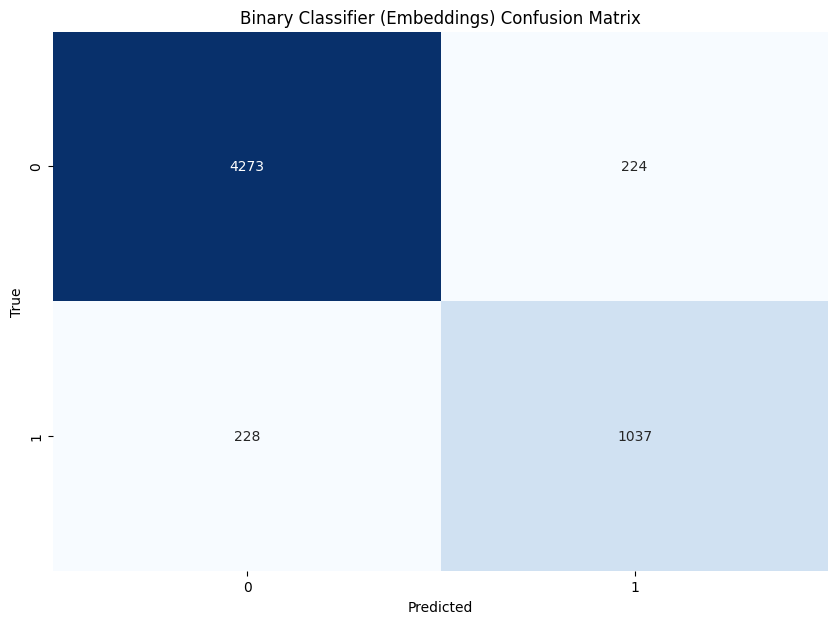

In [71]:
all_preds, all_labels = evaluate_model(classifier_v3, emb_test_dataloader, device)
y_pred = np.argmax(all_preds, axis=1)
plot_confusion_matrix(all_labels, y_pred, title='Binary Classifier (Embeddings) Confusion Matrix')

In [96]:
torch.save(classifier_v3.state_dict(), "../models/EMBClassifier.pth")

### Feature Importance

In [72]:
all_preds, all_labels = evaluate_model(classifier_v3, emb_test_dataloader, device)
y_pred = np.argmax(all_preds, axis=1)

baseline_roc_auc = roc_auc_score(all_labels, all_preds[:, 1])

Evaluating: 100%|██████████| 181/181 [00:01<00:00, 172.20it/s]

Accuracy: 0.9216
ROC AUC: 0.9736
Average Precision: 0.9229


In [ ]:
from itertools import combinations
def permutation_importance_dataloader_advanced(
    model,
    dataloader,
    emb_categorical_columns,
    numeric_columns,
    baseline_score,
    device,
    max_group_size=1
):
    model.eval()
    importances = []

    feature_info = [('cat', i, col) for i, col in enumerate(emb_categorical_columns)] + \
                   [('num', i, col) for i, col in enumerate(numeric_columns)]

    for k in range(1, max_group_size + 1):
        for group in combinations(feature_info, k):
            y_true = []
            y_pred = []
            group_names = [feat[2] for feat in group]

            for x_cat_batch, x_num_batch, y_batch in tqdm(dataloader, desc=f"Permuting {group_names}", leave=False):
                x_cat_batch = x_cat_batch.clone()
                x_num_batch = x_num_batch.clone()

                for feat_type, idx, _ in group:
                    if feat_type == 'cat':
                        perm = x_cat_batch[:, idx][torch.randperm(x_cat_batch.size(0))]
                        x_cat_batch[:, idx] = perm
                    else:
                        perm = x_num_batch[:, idx][torch.randperm(x_num_batch.size(0))]
                        x_num_batch[:, idx] = perm

                x_cat_batch = x_cat_batch.to(device)
                x_num_batch = x_num_batch.to(device)
                y_batch = y_batch.to(device)

                with torch.no_grad():
                    outputs = model(x_cat_batch, x_num_batch)
                    preds = torch.argmax(outputs, dim=1)

                y_true.append(y_batch.cpu().numpy())
                y_pred.append(preds.cpu().numpy())

            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            permuted_score = roc_auc_score(y_true, y_pred)
            importance = baseline_score - permuted_score

            importances.append((group_names, importance))

    return sorted(importances, key=lambda x: x[1], reverse=True)


In [79]:
numeric_columns = emb_numerical_columns.tolist()

importances = permutation_importance_dataloader_advanced(
    model=classifier_v3,
    dataloader=emb_val_dataloader,
    emb_categorical_columns=emb_categorical_columns,
    numeric_columns=numeric_columns,
    baseline_score=baseline_roc_auc,
    device=device,
    max_group_size=2
)

In [80]:
print("\nPermutation Feature Importances (by ROC AUC drop):")
for col, drop in importances:
    print(f"{col}: {drop:.4f}")


Permutation Feature Importances (by ROC AUC drop):
['host_is_superhost', 'review_scores_value']: 0.4473
['review_scores_value', 'num_of_top_10_common_amenities']: 0.4080
['bedrooms', 'review_scores_value']: 0.4034
['bathrooms', 'review_scores_value']: 0.3941
['review_scores_accuracy', 'review_scores_value']: 0.3939
['license', 'review_scores_value']: 0.3935
['room_type', 'review_scores_value']: 0.3934
['review_scores_value', 'count_positive_english']: 0.3932
['review_scores_value', 'total_english_reviews']: 0.3930
['review_scores_value']: 0.3923
['property_type', 'review_scores_value']: 0.3903
['review_scores_rating', 'review_scores_value']: 0.3884
['review_scores_value', 'total_reviews']: 0.3876
['review_scores_value', 'reviews_per_month']: 0.3872
['review_scores_value', 'total_bookings']: 0.3868
['latitude', 'review_scores_value']: 0.3864
['bathrooms_text', 'review_scores_value']: 0.3856
['mean_embedding', 'review_scores_value']: 0.3838
['beds', 'review_scores_value']: 0.3827
['long

## XGBoost - OHE

In [84]:
final_df_ohe.head(5)


,host_is_superhost,host_verifications,host_acceptance_rate,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,...,target,total_reviews,total_english_reviews,count_negative_english,count_positive_english,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities
0,t,"['email', 'phone']",100.0,37.98924,23.76500,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,29.0,17.0,0.0,17.0,37,25,True,False,9
1,f,"['email', 'phone']",96.0,37.96215,23.72179,Entire rental unit,Entire home/apt,4,1.0,1 bath,...,short,97.0,82.0,0.0,82.0,21,12,True,True,7
2,t,"['email', 'phone', 'work_email']",97.0,37.95523,23.72443,Entire condo,Entire home/apt,3,1.0,1 bath,...,long,40.0,31.0,0.0,31.0,49,29,True,True,12
3,f,['email'],0.0,37.99745,23.73973,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,18.0,17.0,1.0,16.0,20,13,True,True,6
4,t,"['email', 'phone']",100.0,37.98844,23.73845,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,long,515.0,423.0,3.0,420.0,45,31,True,True,9


In [87]:
ohe_df = pd.get_dummies(final_df_ohe, columns=non_numerical_columns)
ohe_df["target"].head(5)

0    short
1    short
2     long
3    short
4     long
Name: target, dtype: object

In [88]:
def clean_column_names(df):
    df_cleaned = df.copy()

    new_columns = {}
    for col in df_cleaned.columns:
        if any(char in str(col) for char in ['[', ']', '<', '>']):
            new_col = str(col)
            if '[]' in new_col:
                new_col = new_col.replace('[]', '')
            else:
                new_col = new_col.replace('[', '_').replace(']', '_').replace("'", "").replace(', ', '_')

            while '__' in new_col:
                new_col = new_col.replace('__', '_')

            new_col = new_col.rstrip('_')

            new_columns[col] = new_col

    df_cleaned = df_cleaned.rename(columns=new_columns)
    return df_cleaned

df_cleaned = clean_column_names(ohe_df)


In [89]:
x_train, x_test, y_train, y_test = train_test_split_data(
    df_cleaned,
    test_size=0.2,
    target_column='target'
)

In [90]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [93]:
y_pred = xgb_classifier.predict(x_test)

y_pred_proba = xgb_classifier.predict_proba(x_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba[:, 1]):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9715
ROC AUC: 0.9959
Average Precision: 0.9860

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4497
           1       0.94      0.93      0.93      1265

    accuracy                           0.97      5762
   macro avg       0.96      0.96      0.96      5762
weighted avg       0.97      0.97      0.97      5762



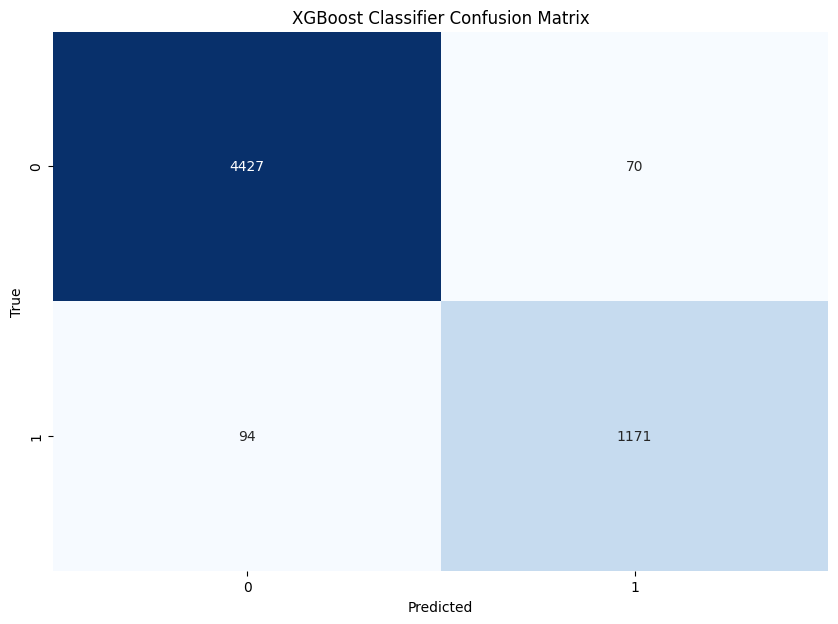

In [94]:
plot_confusion_matrix(y_test, y_pred, title='XGBoost Classifier Confusion Matrix')

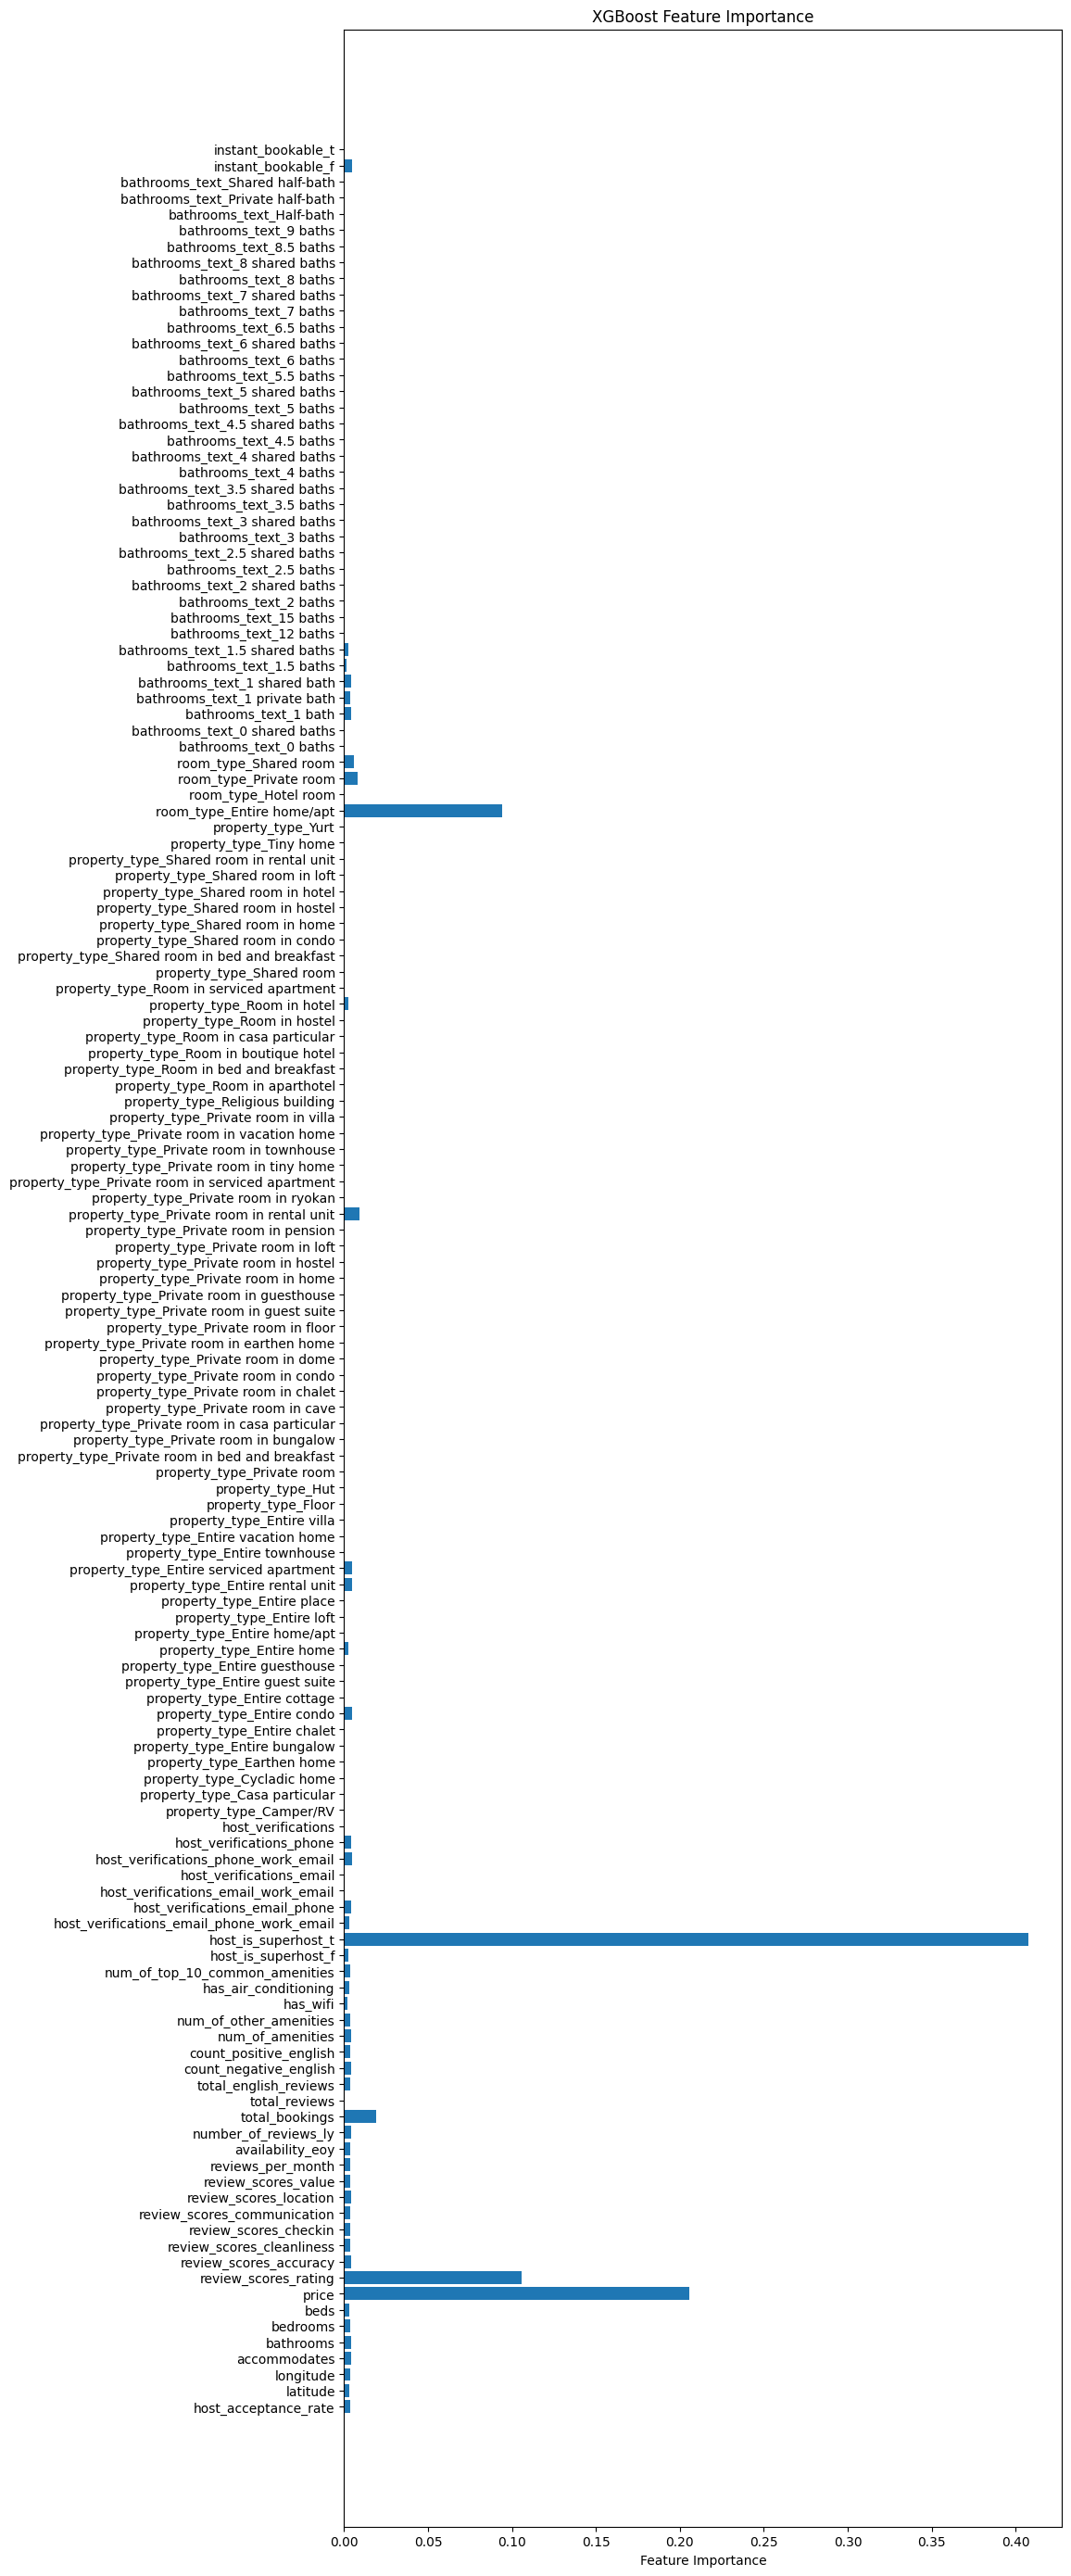

In [95]:
importances = xgb_classifier.feature_importances_

plt.figure(figsize=(10, 35))
plt.barh(x_train.columns, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()